# Задаем функцию из задания, считаем градиент аналитическим и численным методом

Формула для численного метода:
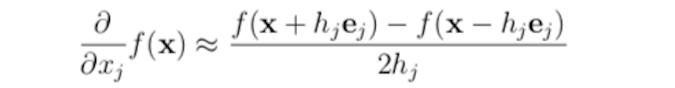

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def target_function(x):
  #функция из задания 0.5*(x1^2 + (x1-x2)^2 + (x2-x3)^2 + x3^2) - x1

  x1, x2, x3 = x
  return 0.5*(x1**2 + (x1-x2)**2 + (x2-x3)**2 + x3**2) - x1

def analyt_gradient(x):
  '''
аналитический градиент - вектор, состоящий из частных производных функции
В нашем случае 3 производных - по x1, x2, x3
0.5x1^2 + 0.5(x1^2 - 2x1x2 + x2^2) + 0.5(x2^2 - 2x2x3 + x3^2) - x1
По x1: 2x1 - 2x2 - 1
По x2: -x1 + 2x2 - x3
По x3: -x2 + 2x3
  '''

  x1, x2, x3 = x
  df_dx1 = 2*x1 - x2 - 1
  df_dx2 = -x1 + 2*x2 - x3
  df_dx3 = -x2 + 2*x3

  return np.array([df_dx1, df_dx2, df_dx3])

def num_gradient (x, h=1e-6):
  #не считаем производные руками
  #в справочных материалах там две формулы, 6 и 7. я так понял не принципиально какую использовать (вторая точнее)

  grad = np.zeros_like(x)

  for i in range (len(x)):
    x_plus = x.copy()
    x_minus = x.copy()
    x_plus[i] += h
    x_minus[i] -= h

    grad[i] = (target_function(x_plus) - target_function(x_minus)) / (2*h)

  return grad





In [ ]:
def check_function_and_gradient():
    """
    Проверим, что функция и градиент вычисляются правильно
    """
    test_point = np.array([1.0, 2.0, 3.0])

    print("Проверка функции и градиента:")
    print(f"Точка: {test_point}")
    print(f"f(x) = {target_function(test_point):.6f}")
    print(f"Аналитический градиент: {analyt_gradient(test_point)}")
    print(f"Численный градиент:     {num_gradient(test_point)}")

    # Проверим разницу между аналитическим и численным градиентом
    analytic = analyt_gradient(test_point)
    numeric = num_gradient(test_point)
    diff = np.linalg.norm(analytic - numeric)
    print(f"Разница: {diff:.10f}")

    return diff < 1e-6  # Должна быть очень маленькой

check_function_and_gradient()

Проверка функции и градиента:
Точка: [1. 2. 3.]
f(x) = 5.000000
Аналитический градиент: [-1.  0.  4.]
Численный градиент:     [-1.  0.  4.]
Разница: 0.0000000006


np.True_

# Алгоритм линейного поиска

Линейный поиск - способ найти длину шага альфа

Условия Вольфе - два условия, по которым мы проверяем сделали ли мы оптимальный шаг

Для проверки вводятся произвольные константы c1 и c2

In [ ]:
def line_search(f, grad_f, x, p, c1=1e-4, c2=0.9, max_iter=50):

  alpha = 1.0
  alpha_prev = 0.0
  f_x = f(x)
  grad_x = grad_f(x)
  grad_x_p = np.dot(grad_x, p)

  for i in range (max_iter):
    x_new = x + alpha * p
    f_new = f(x_new)

    if f_new > f_x + c1 * alpha * grad_x_p or (i>0 and f_new >= f(x + alpha_prev * p)):
      return zoom(f, grad_f, x, p, alpha_prev, alpha, c1, c2)

    grad_new = grad_f(x_new)
    grad_new_p = np.dot(grad_new, p)

    if grad_new_p >= c2 * grad_x_p:
      return alpha

    if grad_new_p >= 0:
      return zoom(f, grad_f, x, p, alpha_prev, alpha, c1, c2)

    alpha_prev = alpha
    alpha = min(alpha * 1.5, 10.0)

  return alpha

def zoom(f, grad_f, x, p, alpha_low, alpha_high, c1, c2, max_iter=20):

  f_x=f(x)
  grad_x = grad_f(x)
  grad_x_p = np.dot(grad_x, p)

  for i in range (max_iter):
    alpha_j = 0.5 * (alpha_low + alpha_high)
    x_j = x + alpha_j * p
    f_j = f(x_j)
    if f_j > f_x + c1 * alpha_j * grad_x_p or f_j >= f(x + alpha_low * p):
      alpha_high = alpha_j
    else:
      grad_j = grad_f(x_j)
      grad_j_p = np.dot(grad_j, p)

      if grad_j_p >= c2 * grad_x_p:
        return alpha_j

      if grad_j_p * (alpha_high - alpha_low) >= 0:
        alpha_high = alpha_low

      alpha_low = alpha_j

  return 0.5 * (alpha_low + alpha_high)

#Матрица Гессе

По заданию нужно реализовать два варианта:

Произвольную матрицу (я взял единичную матрицу, она приводилась в пример)

И через вычисленные на основе конечных разностей частные производные

Собственно в этой части есть параметр выбора метода

Насколько я понял, в BFGS приближают обратную матрицу, поэтому в конце я возвращаю обратную

In [ ]:
def init_hessian (x0, f, method="identity", h=1e-5):
  n=len(x0)
  if method == "identity":
    return np.eye(n)
  else:
    H = np.zeros((n, n))
    f_x = f(x0)
    for i in range(n):
      e_i = np.zeros(n)
      e_i[i] = 1.0
      for j in range(n):
        e_j = np.zeros(n)
        e_j[j] = 1.0
        f_ij = f(x0 + h * e_i + h * e_j)
        f_i = f(x0 + h * e_i)
        f_j = f(x0 + h * e_j)
        H[i, j] = (f_ij - f_i - f_j + f_x) / (h**2)
    return np.linalg.inv(H)

# Алгортим BFGS
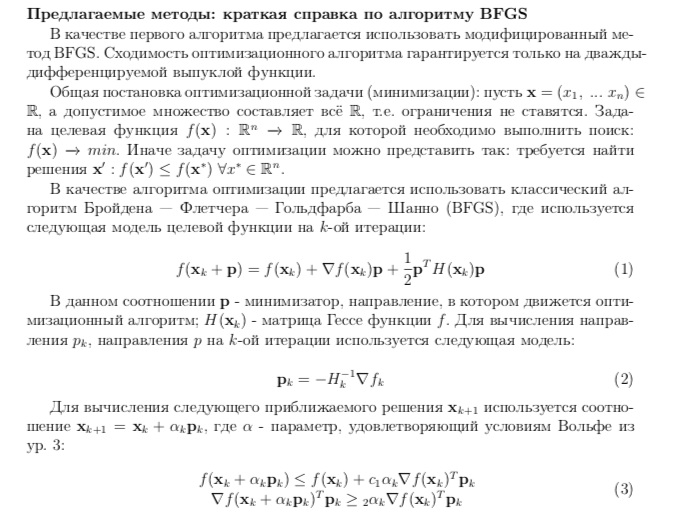

In [ ]:
def bfgs_optimize(x0, grad_type='analytical', max_iter=100, tol=1e-6, hess_init="identity"):
    """Основная функция BFGS оптимизации"""
    if grad_type == 'analytical':
        grad_func = analyt_gradient
    else:
        grad_func = num_gradient

    n = len(x0)
    x = x0.copy()
    H = init_hessian(x, target_function, method=hess_init)

    history = {
        'x': [x.copy()],
        'f': [target_function(x)],
        'grad_norm': [np.linalg.norm(grad_func(x))]
    }

    print(f"Начальная точка: {x}, f(x) = {target_function(x):.6f}")

    for k in range(max_iter):
        grad = grad_func(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm < tol:
            print(f"Сошлось за {k} итераций!")
            break

        p = -H @ grad
        alpha = line_search(target_function, grad_func, x, p)

        x_old = x.copy()
        grad_old = grad.copy()
        x = x + alpha * p
        grad_new = grad_func(x)

        s = x - x_old
        y = grad_new - grad_old

        if np.dot(y, s) > 1e-10:
            rho = 1.0 / np.dot(y, s)
            I = np.eye(n)
            term1 = I - rho * np.outer(s, y)
            term2 = I - rho * np.outer(y, s)
            H = term1 @ H @ term2 + rho * np.outer(s, s)

        history['x'].append(x.copy())
        history['f'].append(target_function(x))
        history['grad_norm'].append(np.linalg.norm(grad_func(x)))

        if k % 10 == 0:
            print(f"Итерация {k}: f(x) = {target_function(x):.8f}, ||∇f|| = {grad_norm:.8f}")

    print(f"Финальная точка: {x}, f(x) = {target_function(x):.10f}")
    print(f"Градиент: {grad_func(x)}, норма: {np.linalg.norm(grad_func(x)):.10f}")

    return x, history



# L-BFGS

Очень похож на предыдущий алгортим, но более экономен, так как мы не храним целую матрицу, а только m последних шагов (в конкретном случае 10)

In [ ]:
def lbfgs_optimize(x0,  f_func, grad_type='analytical', m=10, max_iter=100, tol=1e-6):
  if grad_type == 'analytical':
      grad_func = analyt_gradient
  else:
      grad_func = num_gradient

  x = x0.copy()
  n=len(x)
  s_list=[]
  y_list=[]
  rho_list = []

  f_x = f_func(x)
  g = grad_func(x)

  history = {
        'x': [x.copy()],
        'f': [f_func(x)],
        'grad_norm': [np.linalg.norm(grad_func(x))]
    }

  for k in range(max_iter):
    grad_norm = np.linalg.norm(g)
    if grad_norm < tol:
      print(f"Сошлось за {k} итераций.")
      break

    q = g.copy()
    alpha = []

    for i in reversed(range(len(s_list))):
      rho = rho_list[i]
      s, y = s_list[i], y_list[i]
      a = rho * np.dot(s, q)
      alpha.append(a)
      q -= a * y

    if len(s_list) > 0:
      y, s = y_list[-1], s_list[-1]
      gamma = np.dot(s, y) / np.dot(y, y)
    else:
      gamma = 1.0
    r = gamma * q

    for i in range(len(s_list)):
      s, y = s_list[i], y_list[i]
      rho = rho_list[i]
      b = rho * np.dot(y, r)
      r += s * (alpha[-(i+1)] - b)

    p = -r

    alpha_k = line_search(f_func, grad_func, x, p)
    x_new = x + alpha_k * p
    g_new = grad_func(x_new)

    s = x_new - x
    y = g_new - g

    if np.dot(y, s) > 1e-10:
      rho = 1.0 / np.dot(y, s)
      s_list.append(s)
      y_list.append(y)
      rho_list.append(rho)
      if len(s_list) > m:
        s_list.pop(0)
        y_list.pop(0)
        rho_list.pop(0)

    x, g = x_new, g_new
    f_x = f_func(x)
    history['x'].append(x.copy())
    history['f'].append(f_func(x))
    history['grad_norm'].append(np.linalg.norm(grad_func(x)))

    if k % 10 -- 0:
      print(f"Итерация {k}: f(x) = {f_x:.8f}, |grad| = {grad_norm:.8f}")
  print(f"Финальная точка: {x}, f(x) = {f_x:.8f}")
  return x, history


# Тестирование

Первая часть - считаем минимум аналитически, чтоб потом сравнить с полученным и вычислить ошибку

Часть с реальным тестированием полностью написана чатом гпт:)

Меня смущает как быстро сходится бфгс с матрицей с конечными разностями

Но в целом, L-BFGS требует больше итераций для поиска минимума, но использует меньше памяти, что особенно было бы заметно при росте размерности задача

In [ ]:
# ==================== 4. ТЕСТИРОВАНИЕ И АНАЛИЗ ====================

def find_true_minimum():
    """
    Найдём истинный минимум аналитически, чтобы проверить алгоритм
    Минимум достигается когда градиент = 0:
    2x₁ - x₂ - 1 = 0
    -x₁ + 2x₂ - x₃ = 0
    -x₂ + 2x₃ = 0
    """
    # Решаем систему уравнений:
    # Из третьего уравнения: x₃ = x₂/2
    # Подставляем во второе: -x₁ + 2x₂ - x₂/2 = 0 → -x₁ + 1.5x₂ = 0 → x₁ = 1.5x₂
    # Подставляем в первое: 2*(1.5x₂) - x₂ - 1 = 0 → 3x₂ - x₂ - 1 = 0 → 2x₂ = 1 → x₂ = 0.5
    # Тогда: x₁ = 1.5*0.5 = 0.75, x₃ = 0.5/2 = 0.25

    true_min = np.array([0.75, 0.5, 0.25])
    min_value = target_function(true_min)

    print("=" * 50)
    print("АНАЛИТИЧЕСКОЕ РЕШЕНИЕ:")
    print(f"Истинный минимум: x = {true_min}")
    print(f"f(x_min) = {min_value:.10f}")
    print(f"Градиент в минимуме: {analyt_gradient(true_min)}")
    print("=" * 50)

    return true_min, min_value



In [ ]:

if __name__ == "__main__":
    # Проверка корректности функции и градиента
    check_ok = check_function_and_gradient()
    print(f"Проверка пройдена: {check_ok}\n")

    # Истинный минимум
    true_min, true_min_value = find_true_minimum()

    # Тестовые стартовые точки
    test_points = [
        np.array([0.0, 0.0, 0.0]),
        np.array([1.0, 1.0, 1.0]),
        np.array([2.0, -1.0, 3.0])
    ]

    results = []

    for i, x0 in enumerate(test_points):
        print(f"\n{'='*60}")
        print(f"ТЕСТ {i+1}: Начальная точка {x0}")
        print(f"{'='*60}")

        # --- BFGS (разные варианты инициализации) ---
        for hess_init in ["identity", "finite_diff"]:
            print(f"\n--- BFGS ({hess_init}), аналитический градиент ---")
            x_bfgs_analyt, hist_bfgs_analyt = bfgs_optimize(
                x0, grad_type='analytical', max_iter=100, tol=1e-8, hess_init=hess_init
            )

            print(f"\n--- BFGS ({hess_init}), численный градиент ---")
            x_bfgs_num, hist_bfgs_num = bfgs_optimize(
                x0, grad_type='numerical', max_iter=100, tol=1e-8, hess_init=hess_init
            )

            err_a = np.linalg.norm(x_bfgs_analyt - true_min)
            err_n = np.linalg.norm(x_bfgs_num - true_min)

            results.append({
                'start_point': x0,
                'method': f"BFGS ({hess_init})",
                'type': 'analytical',
                'x_opt': x_bfgs_analyt,
                'error': err_a,
                'iters': len(hist_bfgs_analyt['f'])
            })
            results.append({
                'start_point': x0,
                'method': f"BFGS ({hess_init})",
                'type': 'numerical',
                'x_opt': x_bfgs_num,
                'error': err_n,
                'iters': len(hist_bfgs_num['f'])
            })

        # --- L-BFGS ---
        print("\n--- L-BFGS (аналитический градиент) ---")
        x_lbfgs_analyt, hist_lbfgs_analyt = lbfgs_optimize(
            x0, grad_type='analytical', f_func=target_function,
            m=5, max_iter=100, tol=1e-8
        )

        print("\n--- L-BFGS (численный градиент) ---")
        x_lbfgs_num, hist_lbfgs_num = lbfgs_optimize(
            x0, grad_type='numerical', f_func=target_function,
            m=5, max_iter=100, tol=1e-8
        )

        err_lbfgs_a = np.linalg.norm(x_lbfgs_analyt - true_min)
        err_lbfgs_n = np.linalg.norm(x_lbfgs_num - true_min)

        results.append({
            'start_point': x0,
            'method': "L-BFGS",
            'type': 'analytical',
            'x_opt': x_lbfgs_analyt,
            'error': err_lbfgs_a,
            'iters': len(hist_lbfgs_analyt['f'])
        })
        results.append({
            'start_point': x0,
            'method': "L-BFGS",
            'type': 'numerical',
            'x_opt': x_lbfgs_num,
            'error': err_lbfgs_n,
            'iters': len(hist_lbfgs_num['f'])
        })

    # --- Сводка результатов ---
    print(f"\n{'='*100}")
    print("СВОДКА РЕЗУЛЬТАТОВ:")
    print(f"{'='*100}")
    print("Истинный минимум:", true_min, "\n")

    for res in results:
        print(f"Метод: {res['method']:<14} | Тип градиента: {res['type']:<10} | "
              f"Нач. точка: {res['start_point']} | "
              f"Ошибка = {res['error']:.2e}, Итераций = {res['iters']}")



Проверка функции и градиента:
Точка: [1. 2. 3.]
f(x) = 5.000000
Аналитический градиент: [-1.  0.  4.]
Численный градиент:     [-1.  0.  4.]
Разница: 0.0000000006
Проверка пройдена: True

АНАЛИТИЧЕСКОЕ РЕШЕНИЕ:
Истинный минимум: x = [0.75 0.5  0.25]
f(x_min) = -0.3750000000
Градиент в минимуме: [0. 0. 0.]

ТЕСТ 1: Начальная точка [0. 0. 0.]

--- BFGS (identity), аналитический градиент ---
Начальная точка: [0. 0. 0.], f(x) = 0.000000
Итерация 0: f(x) = -0.25000000, ||∇f|| = 1.00000000
Сошлось за 7 итераций!
Финальная точка: [0.75       0.5        0.24999999], f(x) = -0.3750000000
Градиент: [ 0.00000000e+00 -3.37897210e-10 -8.87634377e-09], норма: 0.0000000089

--- BFGS (identity), численный градиент ---
Начальная точка: [0. 0. 0.], f(x) = 0.000000
Итерация 0: f(x) = -0.25000000, ||∇f|| = 1.00000000
Сошлось за 7 итераций!
Финальная точка: [0.75       0.5        0.24999999], f(x) = -0.3750000000
Градиент: [ 0.00000000e+00 -2.77555756e-10 -8.90953977e-09], норма: 0.0000000089

--- BFGS (fin